In [2]:
import pandas as pd
data = pd.read_csv("/content/MSFT.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,83.599998,84.809998,83.220001,84.260002,78.978004,29532100
1,2017-12-04,84.419998,84.430000,80.699997,81.080002,75.997337,39094900
2,2017-12-05,81.339996,82.680000,80.980003,81.589996,76.475357,26152300
3,2017-12-06,81.550003,83.139999,81.430000,82.779999,77.590767,26162100
4,2017-12-07,82.540001,82.800003,82.000000,82.489998,77.318954,23184500


In [3]:
data['Date'] =pd.to_datetime(data['Date'])
data.index= data['Date']

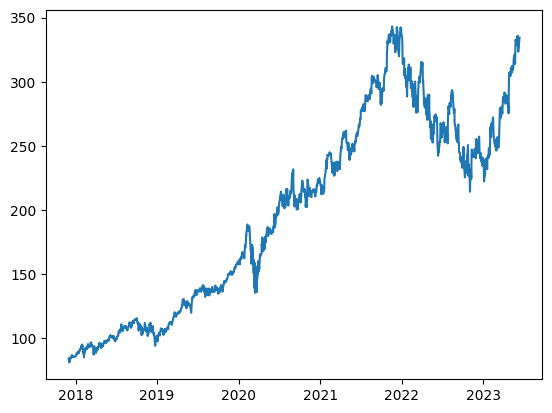

In [4]:
import matplotlib.pyplot as plt
plt.plot(data.index,data['Close'])

In [5]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [6]:
# 2. Đọc file dữ liệu chứng khoán DELL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/MSFT.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index



# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [7]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.9 MB/s eta 0:00:00


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
fit = model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4182.847, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4249.077, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4179.733, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4186.293, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4249.980, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4181.733, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4181.733, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4183.590, Time=1.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4182.933, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.386 seconds


In [9]:
train_data.index

RangeIndex(start=0, stop=834, step=1)

In [10]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [11]:

from datetime import timedelta

In [12]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
#last_index =  df.index[-1]
last_index=len(df)
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[235.52763625 236.03575775 236.12501539 236.33440256 236.50933676
 236.69415202 236.87613341 237.05892755 237.24148859 237.42411648
 237.6067252  237.78933942 237.97195206 238.15456516 238.33717812
 238.51979113 238.70240412 238.88501711 239.06763011 239.2502431
 239.43285609 239.61546909 239.79808208 239.98069508 240.16330807
 240.34592106 240.52853406 240.71114705 240.89376005 241.07637304]


In [13]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 33.8005998255854
Testing RMSE: 41.552920421817774


RMSE thường được sử dụng để đánh giá độ chính xác của mô hình dự đoán với các giá trị liên tục, như giá cổ phiếu, điểm số, nhiệt độ, v.v. Giá trị RMSE càng nhỏ, mô hình dự đoán càng chính xác. Vậy với dữ liệu này mô hình Arima chính xác hơn

Validation RMSE: 33.8005998255854
Testing RMSE: 41.552920421817774
Validation MAE: 25.410109242390476
Testing MAE: 35.06058924273492
Validation MAPE: 0.08609341080264306
Testing MAPE: 0.12607053346495625


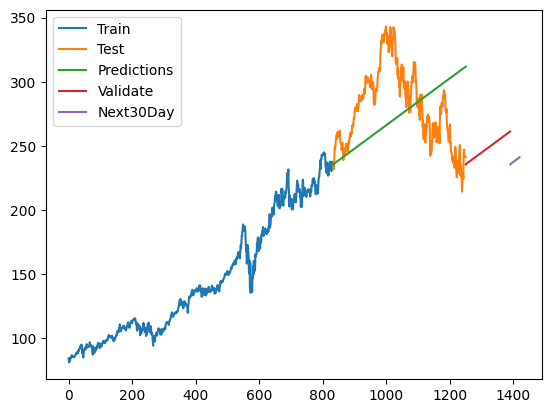

In [14]:


# 8. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mae= np.mean(np.abs(y_pred_val - y_val))
test_mae= np.mean(np.abs(y_pred - y_test))
valid_mape= np.mean(np.abs((y_pred_val - y_val) / y_val))
test_mape= np.mean(np.abs((y_pred - y_test) /y_test))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [15]:
test_data.index

RangeIndex(start=834, stop=1251, step=1)